In [1]:
import numpy as np

a = np.arange(10).astype(int)



r1 = np.array([0,0,0,1,1,1,2,2,2])
r2 = np.array([0,0,0,1,1,1,2,2,2])
r3 = np.array([0,0,0,1,1,1,2,2,2])
r4 = np.array([3,3,3,4,4,4,5,5,5])
r5 = np.array([3,3,3,4,4,4,5,5,5])
r6 = np.array([3,3,3,4,4,4,5,5,5])
r7 = np.array([6,6,6,7,7,7,8,8,8])
r8 = np.array([6,6,6,7,7,7,8,8,8])
r9 = np.array([6,6,6,7,7,7,8,8,8])
blockmap =  np.stack([r1,r2,r3,r4,r5,r6,r7,r8,r9])


x = a
mp = [0,0,0,3,3,3,6,6,6]
cp = [0,3,6,0,3,6,0,3,6]
idmap = np.arange(9).reshape((3,3))

[[0 0 0 0 6 1 0 0 8]
 [0 0 0 2 4 8 0 6 0]
 [6 0 0 0 0 7 0 4 5]
 [0 0 9 6 2 0 4 0 0]
 [8 5 0 0 0 0 0 3 9]
 [0 0 4 0 8 3 5 0 0]
 [7 8 0 4 0 0 0 0 1]
 [0 6 0 8 5 2 0 0 0]
 [5 0 0 1 7 0 0 0 0]]


In [2]:
def getblock(b,idx):
	ridx = mp[idx]
	cidx = cp[idx]
	return b[ridx:ridx+3,cidx:cidx+3]

def getrow(b,idx):
	return b[idx,:]
	
def getcol(b,idx):
	return b[:,idx].T

def get_empty_squares(block):
	return np.stack(np.where(block==0),axis=1)

def get_filled_squares(block):
	return np.stack(np.where(block!=0),axis=1)

def getpossible(b,block,r,c):
	rowcol = np.concatenate([a,block.reshape(9),getrow(b,r),getcol(b,c)])
	rcbins = np.bincount(rowcol)-2
	valid_values_for_square = a[1:][rcbins[1:]<0]
	return valid_values_for_square.astype(int)
	

def cart2idx(cart):
	return int(cart[0] * 9 + cart[1])

def idx2cart(idx):
	return np.array([idx//9, idx%9]).astype(int)

def convert_to_unique(row_posns,col_posns, block_posns):
	rp = [cart2idx(row_posns[j]) for j in range(len(row_posns))]
	cp = [cart2idx(col_posns[j]) for j in range(len(col_posns))]
	bp = [cart2idx(block_posns[j]) for j in range(len(block_posns))]
	up = np.nonzero(np.bincount(np.concatenate([rp,cp,bp]).astype(int)))[0]
	return np.array([idx2cart(up[i]) for i in range(up.shape[0])])
	
def get_modded_squares(b,r,c):
	# gets modified squares
	i = blockmap[r,c]
	row_add = mp[i]
	col_add = cp[i]
	block_posns = get_empty_squares(getblock(b,i))	
	block_posns[:,0]+=row_add
	block_posns[:,1]+=col_add
	# block = getblock(b,i)
	row = getrow(b,r)
	col = getcol(b,c)
	row_posns = get_empty_squares(row).squeeze(-1)
	col_posns = get_empty_squares(col).squeeze(-1)
	r = np.repeat(r,row_posns.shape[0])
	c = np.repeat(c,col_posns.shape[0])
	row_posns = np.stack([r,row_posns],axis=1)
	col_posns = np.stack([col_posns,c],axis=1)
	rowcol_posns = convert_to_unique(row_posns,col_posns,block_posns)
	return rowcol_posns

def get_rowcol_possible(b,rowcol_posns):
	# gets possible values given a list of squares
	rowcol_possible = [getpossible(b,getblock(b,blockmap[rowcol_posns[j,0],rowcol_posns[j,1]]) ,rowcol_posns[j,0],rowcol_posns[j,1]) for j in range(rowcol_posns.shape[0])]
	return rowcol_possible

def pad_out(block_run,maxlen):
	#pc = np.array(posn_counter)
	for j in range(81):
		i = idx2cart(j)
		block_run[i[0]][i[1]] = np.concatenate([block_run[i[0]][i[1]].astype(int),np.zeros((maxlen - block_run[i[0]][i[1]].shape[0])).astype(int)-1])
		int_mask = np.ones((maxlen))
		int_mask[np.nonzero(block_run[i[0]][i[1]] + 1)] = False
		
	return np.array(block_run)

def _partial_pad(block_run,brx,posns,pos_lens,prx, maxlen):
	for j,i in enumerate(posns):
		block_run[i[0]][i[1]] = np.concatenate([brx[j].astype(int),np.zeros((maxlen - brx[j].shape[0])).astype(int)-1])
		pos_lens[i[0]][i[1]] = prx[j]
	return np.array(block_run),np.array(pos_lens)

def partial_pad(block_run,posns,maxlen):
	block_posns = np.zeros((posns.shape[0]))
	for j,i in enumerate(posns):
		block_posns[j] = block_run[j].shape[0]
		block_run[j] = np.concatenate([block_run[j].astype(int),np.zeros((maxlen - block_run[j].shape[0])).astype(int)-1])
	if len(posns)<=1:
		print("foo")
	return np.array(block_run),block_posns

def set_map(b,blocks_to_update):
	i = [[] for _ in range(9)]
	block_run = i
	posn_counter = [[] for _ in range(9)]
	for j in range(len(block_run)):
		for i in range(9):
			block_run[j].append(np.empty(1))
			posn_counter[j].append(0)
	for i in blocks_to_update:
		row_add = mp[i]
		col_add = cp[i]
		block = getblock(b,i)
		es = get_empty_squares(block)
		es[:,0] += row_add
		es[:,1] += col_add
		for j in es:
			r,c = j[0], j[1]
			block_run[r][c] = getpossible(b,block,r,c)
			posn_counter[r][c] = len(block_run[r][c])
	posn_counter = np.array(posn_counter)
	maxlen = np.max(posn_counter)
	return block_run,posn_counter,maxlen
	
		#print(block_run[i[0]][i[1]].shape)
	return pad_out(block_run,maxlen),posn_counter,maxlen


def assign_trivial(b,masks,possibilities,posn_counters):	
	es = get_empty_squares(b)
	index_trivial = posn_counters[es[:,0],es[:,1]] == 1
	trivial = posn_counters == 1
	print(np.nonzero(trivial))
	b[trivial] = possibilities[trivial,0]
	masks[np.nonzero(index_trivial),0] = False
	# masks[trivial, 0] = False
	# posn_counters[trivial] = 0
	# possibilities[trivial] = np.zeros(possibilities[trivial].shape).astype(int) - 1
def get_sblock(r=9):
  cs = [deque()] * r
  for i in range(r):
    cs[i].extend([deque()* r])
  return cs


In [3]:
def create_mask(posns, pos_lens, maxlen):
  block_run = np.array([np.zeros((maxlen)).astype(bool) for _ in range(len(posns))])
  # block_run = i
  # for i in range(9):
  #   for j in range(9):
  #     block_run[i]
  # print(pos_lens[0,0])
  for j,i in enumerate(posns):
    # print(i)
    # print([])
    # print(i)
    # print(np.arange(pos_lens[i[0],i[1]]))
    block_run[j][0:pos_lens[i[0],i[1]]] = True
  return np.array(block_run)

def update_mask(current_masks, constraints, intermediate_constraints, intermediate_posns):
  for j,i in enumerate(intermediate_posns):
    r,c = i[0],i[1]
    # print(intermediate_constraints[j])
    # print(np.isin(constraints[r,c], np.intersect1d(constraints[r,c],intermediate_constraints[j])))
    current_masks[j] = current_masks[j] * np.isin(constraints[r,c], np.intersect1d(constraints[r,c],intermediate_constraints[j]))
    # return current_masks
  return current_masks

In [41]:
from collections import deque
blocks_to_check = deque([0,1,2,3,4,5,6,7,8])
# b = np.array([[0,0,0,0,6,1,0,0,8],
# [0,0,0,2,4,8,0,6,0],
# [6,0,0,0,0,7,0,4,5],
# [0,0,9,6,2,0,4,0,0],
# [8,5,0,0,0,0,0,3,9],
# [0,0,4,0,8,3,5,0,0],
# [7,8,0,4,0,0,0,0,1],
# [0,6,0,8,5,2,0,0,0],
# [5,0,0,1,7,0,0,0,0]])
# print(b)
#es = get_empty_squares(b)
r1 = np.array([3,0,5,4,0,2,0,6,0])
r2 = np.array([4,9,0,7,6,0,1,0,8])
r3 = np.array([6,0,0,1,0,3,2,4,5])
r4 = np.array([0,0,3,9,0,0,5,8,0])
r5 = np.array([9,6,0,0,5,8,7,0,3])
r6 = np.array([0,8,1,3,0,0,0,9,2])
r7 = np.array([0,5,0,6,0,1,4,0,0])
r8 = np.array([2,0,0,5,4,9,0,7,0])
r9 = np.array([1,4,9,0,0,7,3,0,6])
b = np.stack([r1,r2,r3,r4,r5,r6,r7,r8,r9])
# r1 = np.array([0,0,0,9,8,0,0,7,0])
# r2 = np.array([8,0,1,4,0,0,0,0,0])
# r3 = np.array([0,5,0,7,0,0,0,0,4])
# r4 = np.array([2,0,8,0,7,0,0,9,0])
# r5 = np.array([0,1,0,6,9,4,0,2,0])
# r6 = np.array([0,4,0,0,1,0,7,0,5])
# r7 = np.array([4,0,0,0,0,3,0,1,0])
# r8 = np.array([0,0,0,0,0,7,9,0,3])
# r9 = np.array([0,8,0,0,6,9,0,0,0])
# b = np.stack([r1,r2,r3,r4,r5,r6,r7,r8,r9])
# print(b)
b
constraints,pos_lens,maxlen = set_map(b,blocks_to_check)
constraints = pad_out(constraints, maxlen)
# print(constraints)
es = get_empty_squares(b)
print(pos_lens)
# print(b)
print(pos_lens)

# def get_trivial(masks, tainted_squares)
# print(es)
masks1 = create_mask(es,pos_lens, maxlen)
# print(masks1)
# print(constraints)
# print(es[0])
# print(b[es[0,0],es[0,1]])
r,c = es[0].tolist()
b[r,c] = constraints[r,c][0]
modified_squares = get_empty_squares(b,r,c)
# print(constraints[])
intermediate_constraints = get_rowcol_possible(b,modified_squares)


# print(modified_squares)
# print(intermediate_constraints)
# print(modified_squares[0])
# print(constraints[modified_squares[0,0],modified_squares[0,1]])
# print(intermediate_constraints[0])
print(masks1.shape)
masks1 = update_mask(masks1 ,constraints, intermediate_constraints, modified_squares)
print(masks1.shape)
print(masks1.shape)
triv_mask = np.sum(masks1,axis=1)==1
trivial = es[triv_mask]
ans = np.nonzero(masks1[triv_mask])[1]
print(b)
b[trivial[:,0],trivial[:,1]] = constraints[trivial[:,0],trivial[:,1], ans]
# print()
print(b)

# print(e1)
# print(b[ ].shape)

# print(pos_lens[r,c])
# print(np.bincount(np.concatenate([np.zeros((1)).astype(int),np.sum(masks1,axis=1)]))[0] > 1)

# adjacency_matrix = np.zeros((b.shape[0]**2,b.shape[0]**2))
# print(adjacency_matrix.shape)
# print(b)
# print(main_loop(b))
# print(masks)

[[0 2 0 0 2 0 1 0 2]
 [0 0 1 0 0 1 0 1 0]
 [0 1 2 0 2 0 0 0 0]
 [1 2 0 0 3 2 0 0 2]
 [0 0 2 1 0 0 0 1 0]
 [2 0 0 0 1 2 1 0 0]
 [2 0 2 0 3 0 0 1 1]
 [0 1 2 0 0 0 1 0 1]
 [0 0 0 2 2 0 0 2 0]]
[[0 2 0 0 2 0 1 0 2]
 [0 0 1 0 0 1 0 1 0]
 [0 1 2 0 2 0 0 0 0]
 [1 2 0 0 3 2 0 0 2]
 [0 0 2 1 0 0 0 1 0]
 [2 0 0 0 1 2 1 0 0]
 [2 0 2 0 3 0 0 1 1]
 [0 1 2 0 0 0 1 0 1]
 [0 0 0 2 2 0 0 2 0]]
(34, 3)
(34, 3)
(34, 3)
[[3 1 5 4 0 2 0 6 0]
 [4 9 0 7 6 0 1 0 8]
 [6 0 0 1 0 3 2 4 5]
 [0 0 3 9 0 0 5 8 0]
 [9 6 0 0 5 8 7 0 3]
 [0 8 1 3 0 0 0 9 2]
 [0 5 0 6 0 1 4 0 0]
 [2 0 0 5 4 9 0 7 0]
 [1 4 9 0 0 7 3 0 6]]
[[3 1 5 4 8 2 9 6 7]
 [4 9 2 7 6 5 1 3 8]
 [6 7 0 1 0 3 2 4 5]
 [7 0 3 9 0 0 5 8 0]
 [9 6 0 2 5 8 7 1 3]
 [0 8 1 3 7 0 6 9 2]
 [0 5 0 6 0 1 4 2 9]
 [2 3 0 5 4 9 8 7 1]
 [1 4 9 0 0 7 3 0 6]]


In [15]:
print(masks1.shape)
print(es.shape)
print(constraints.shape)

(34, 3)
(34, 2)
(9, 9, 3)


In [295]:
def main_loop(b):
  constraints,pos_lens,maxlen = set_map(b,blocks_to_check)
  constraints = pad_out(constraints, maxlen)
  # assign_trivial(b,constraints,pos_lens)
  print(constraints[0,0])
  es = get_empty_squares(b)
  # print(es)
  # print(es.shape)
  s = np.zeros((es.shape[0])).astype(int)
  p = np.zeros((es.shape[0])).astype(int)
  ctx = np.zeros((1)).astype(int)
  history = np.zeros((es.shape[0],2)).astype(int)
  mask_stack = deque()
  mask_stack.append(create_mask(es,pos_lens, maxlen))
  # print(history)
  inner_shift_toggle = np.array([0,-1])
  outer_shift_toggle = np.array([1,-1])
  major_flag = 0
  
  r,c = es[0].tolist()
  # print(r,c)
  # return
  # p[ctx] = pos_lens[r,c]-1
  
  # ctx = 1
  # print(mask_stack[-1][0].shape)
  # r,c = es[ctx].tolist()[0]
  while ctx < es.shape[0]:
    while major_flag < 0:
      minor_flag = -1
      masks = mask_stack[-1].copy()
      while minor_flag < 0 and p[ctx] >= 0:
        while not masks[ctx,p[ctx]] and p[ctx] > 0:
          p[ctx] -= 1
        # print(s[ctx])
        # print(p[ctx])
        # print(constraints[r,c])
        # print(p[ctx])
        # print(constraints[r,c])
        s[ctx] = constraints[r,c][p[ctx]]
        print(s)
        b[r,c] = s[ctx]
        modified_squares = get_empty_squares(b)#get_modded_squares(b,r,c)
        print(modified_squares.shape,'modded')
        intermediate_constraints = get_rowcol_possible(b,modified_squares)
        print(intermediate_constraints)
        # b[r,c] = 0
        print(intermediate_constraints)
        # intermediate_constraints,intermediate_pos_lens = partial_pad(intermediate_constraints, modified_squares, maxlen)
        masks = update_mask(masks ,constraints, intermediate_constraints, modified_squares)
        fault = np.bincount(np.concatenate([np.zeros((1)).astype(int),np.sum(masks,axis=1)]))[0]
        minor_flag = inner_shift_toggle[(fault>1).astype(int)]
        masks[ctx,p[ctx]] = False
        p[ctx] += minor_flag
      major_flag = outer_shift_toggle[(p[ctx] + minor_flag < 0).astype(int)]
      # print(constraints)
      if major_flag < 0:
        if len(mask_stack) > 1:
          masks = mask_stack.pop()
        ctx += major_flag
        b[r,c] = 0
      else:
        # b[r,c] = s[ctx]
        mask_stack.append(np.copy(masks))
        ctx += major_flag
          
      
      if ctx >= es.shape[0]:
        return b
      # if ctx != 0 and major_flag > 0:
      
      r,c = es[ctx].tolist()[0]
    p[ctx] = pos_lens[r,c]-1
    major_flag = -1
      


In [205]:
for (r,c) in es:
  b[r,c] = 1
  rc = cart2idx((r,c))
  mc = np.array([cart2idx(i.T) for i in get_modded_squares(b,r,c)])
  # print(mc)
  adjacency_matrix[rc,mc] += 1
  b[r,c] = 0
  # print(mc)
print(np.nonzero(adjacency_matrix))

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 2

In [206]:
print(adjacency_matrix)
f = open('f.txt','w')
for i,r in enumerate(adjacency_matrix):
  
  f.write(f'{idx2cart(i)}-{idx2cart(np.nonzero(r)[0]).T}\n')
f.close()

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [157]:
import numpy as np

def prim_mst(adj_matrix,first):
    num_vertices = len(adj_matrix)
    # Initialize arrays to keep track of selected vertices and minimum weights
    selected = [False] * num_vertices
    min_weights = [float('inf')] * num_vertices
    # Array to store the MST
    mst = [None] * num_vertices
    
    # Start from vertex 0
    min_weights[0] = first
    mst[0] = -1  # No parent of the first vertex
    
    for _ in range(num_vertices):
        # Find the vertex with the minimum weight that has not been included yet
        u = min_vertex(min_weights, selected,first)
        selected[u] = True
        
        # Update the weights and MST based on the new vertex u
        for v in range(num_vertices):
            if (adj_matrix[u][v] != 0 and not selected[v] and
                adj_matrix[u][v] < min_weights[v]):
                mst[v] = u
                min_weights[v] = adj_matrix[u][v]
    
    return mst

def min_vertex(min_weights, selected,first):
    # Helper function to find the vertex with the minimum weight
    min_weight = float('inf')
    min_vertex = first
    num_vertices = len(min_weights)
    for v in range(num_vertices):
        if not selected[v] and min_weights[v] < min_weight:
            min_weight = min_weights[v]
            min_vertex = v
    return min_vertex

print(cart2idx(es[0]))
mst = prim_mst(adjacency_matrix,cart2idx(es[0]))
print(mst)
print("Edge   Weight")
adjancency_edges = []
for i in range(1, len(adjacency_matrix)):
    if mst[i] != None:
        ms = idx2cart(mst[i])
        mi = idx2cart(i)
        adjancency_edges.append(((ms[0],ms[1]), (mi[0],mi[1])))
        print(idx2cart(mst[i]), "-", idx2cart(i), "   ", adjacency_matrix[i][mst[i]])
        

1
[-1, None, None, None, 1, None, 1, None, 1, None, None, 1, None, None, 4, None, 6, None, None, 1, 1, None, 4, None, None, None, None, 28, 1, None, None, 4, 14, None, None, 8, None, None, 11, 31, None, None, None, 16, None, 28, None, None, None, 4, 14, 6, None, None, 27, None, 11, None, 4, None, None, 16, 8, None, 1, 11, None, None, None, 6, None, 8, None, None, None, 39, 4, None, None, 16, None]
Edge   Weight
[0 1] - [0 4]     1.0
[0 1] - [0 6]     1.0
[0 1] - [0 8]     1.0
[0 1] - [1 2]     1.0
[0 4] - [1 5]     1.0
[0 6] - [1 7]     1.0
[0 1] - [2 1]     1.0
[0 1] - [2 2]     1.0
[0 4] - [2 4]     1.0
[3 1] - [3 0]     1.0
[0 1] - [3 1]     1.0
[0 4] - [3 4]     1.0
[1 5] - [3 5]     1.0
[0 8] - [3 8]     1.0
[1 2] - [4 2]     1.0
[3 4] - [4 3]     1.0
[1 7] - [4 7]     1.0
[3 1] - [5 0]     1.0
[0 4] - [5 4]     1.0
[1 5] - [5 5]     1.0
[0 6] - [5 6]     1.0
[3 0] - [6 0]     1.0
[1 2] - [6 2]     1.0
[0 4] - [6 4]     1.0
[1 7] - [6 7]     1.0
[0 8] - [6 8]     1.0
[0 1] - [7 1]

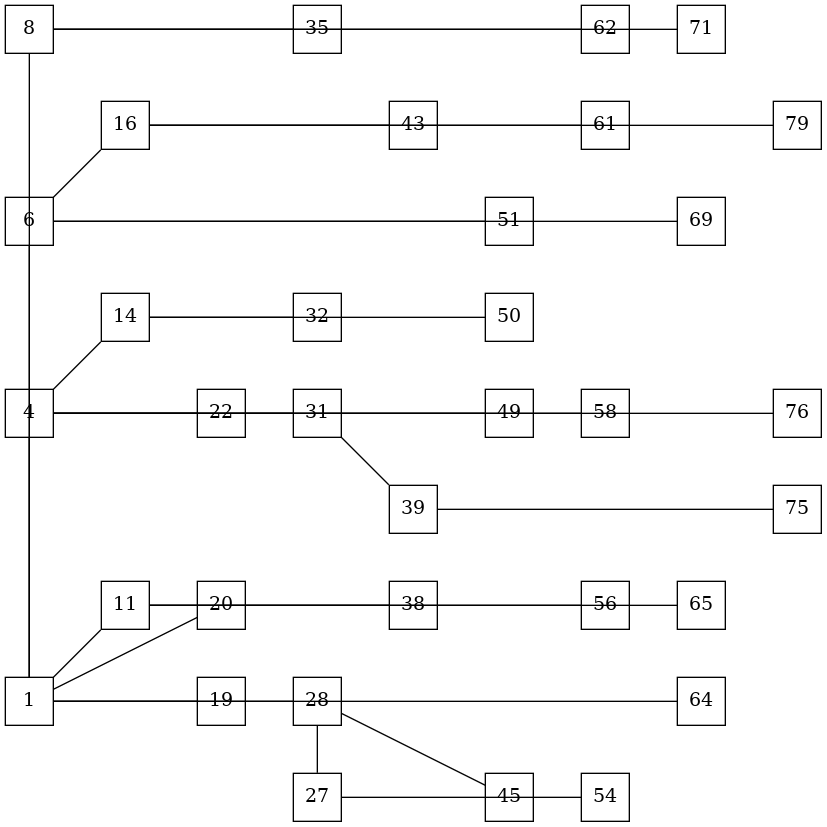

In [207]:
import graphviz

# List of edges with weights
edges = adjancency_edges
# [
#     ((0, 4), (0, 6),0),
#     ((0, 4), (0, 8),0),
#     ((1, 5), (1, 2),0),
#     ((0, 4), (1, 5),0),
#     ((0, 6), (1, 7),0),
#     ((1, 2), (2, 1),0),
#     ((1, 2), (2, 2),0),
#     ((0, 4), (2, 4),0),
#     ((3, 1), (3, 0),0),
#     ((2, 1), (3, 1),0),
#     ((0, 4), (3, 4),0),
#     ((1, 5), (3, 5),0),
#     ((0, 8), (3, 8),0),
#     ((1, 2), (4, 2),0),
#     ((3, 4), (4, 3),0),
#     ((1, 7), (4, 7),0),
#     ((3, 1), (5, 0),0),
#     ((0, 4), (5, 4),0),
#     ((1, 5), (5, 5),0),
#     ((0, 6), (5, 6),0),
#     ((3, 0), (6, 0),0),
#     ((1, 2), (6, 2),0),
#     ((0, 4), (6, 4),0),
#     ((1, 7), (6, 7),0),
#     ((0, 8), (6, 8),0),
#     ((2, 1), (7, 1),0),
#     ((1, 2), (7, 2),0),
#     ((0, 6), (7, 6),0),
#     ((0, 8), (7, 8),0),
#     ((4, 3), (8, 3),0),
#     ((0, 4), (8, 4),0),
#     ((1, 7), (8, 7),0)
# ]

# Create a new graph in Graphviz
dot = graphviz.Graph(comment='Planar Graph', engine='neato')

# Add nodes with coordinates
for edge in edges:
    dot.node(str(edge[0]), label=f'{cart2idx(edge[0])}', pos=f'{edge[0][0]},{edge[0][1]}!', shape='square')
    dot.node(str(edge[1]), label=f'{cart2idx(edge[1])}', pos=f'{edge[1][0]},{edge[1][1]}!', shape='square')

# Add edges with weights
for edge in edges:
    dot.edge(str(edge[0]), str(edge[1]))

# Render the graph to a file
dot.render('planar_graph', format='png', cleanup=True)

# Display the graph
from IPython.display import Image
Image(filename='planar_graph.png')


In [131]:
x = np.copy(b)

In [132]:
x

array([[2, 0, 0, 0, 6, 1, 0, 0, 8],
       [0, 0, 0, 2, 4, 8, 0, 6, 0],
       [6, 0, 0, 0, 0, 7, 0, 4, 5],
       [0, 0, 9, 6, 2, 0, 4, 0, 0],
       [8, 5, 0, 0, 0, 0, 0, 3, 9],
       [0, 0, 4, 0, 8, 3, 5, 0, 0],
       [7, 8, 0, 4, 0, 0, 0, 0, 1],
       [0, 6, 0, 8, 5, 2, 0, 0, 0],
       [5, 0, 0, 1, 7, 0, 0, 0, 0]])